In [2]:
from src import *

In [3]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.gradient import GradientMaps
import seaborn as sns

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- [Standard Sliding window Dynamic (Visualization)](#sliding)

- [Standard Sliding window Dynamic (Analysis)](#slidinganalysis)

In [8]:
mri_path = "./data/fmri_compile.csv"
mri_df   = pd.read_csv(mri_path)

### Standard Sliding window Dynamic
We don't know the TR but expect it to be around 1 sec and so we have 1 min to be 60 sample points. As advised (at least 1 min) for window size we pick 60 frames.

<a class="anchor" id="sliding"></a>
### Visualization

In [40]:
# trim the washimg time for movies before and after
wash  = 90 / TR # duration in seconds for wash is 90 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec
front_pad, bot_pad = int(wash + onset), int(wash - onset)

correlation_measure = ConnectivityMeasure(kind='correlation')

filename_movie = 'TC_400_sub-S09_ses-4_Sintel.csv'
filename_rest  = 'TC_400_sub-S23_ses-1_Rest.csv'

movie_series, movie_df = df_to_timeseries(mri_df, filename_movie)
rest_series, rest_df   = df_to_timeseries(mri_df, filename_rest)

movie_series   = movie_series[front_pad : -bot_pad]

In [41]:
# variable for dFC
ws   = 250
step = 1 # let's overlap pretty much all for now to see smoothness

Computing Dynamic FC for rest

In [42]:
nbr, nbt = rest_series.T.shape

dFC_rest = np.zeros((nbt // step + 1 - ws, nbr,nbr))

for c, sidx in enumerate(range(0, nbt, step)):
    T = rest_series[sidx:sidx+ws]
    if T.shape[0] != ws: 
        continue
    correlation_measure = ConnectivityMeasure(kind='correlation')
    dFC_rest[c] = correlation_measure.fit_transform([T])[0]

correlation_measure = ConnectivityMeasure(kind='correlation')
ref_FC_rest = correlation_measure.fit_transform([rest_series])[0]

Computing Dynamic FC for movie

In [43]:
nbr, nbt = movie_series.T.shape

dFC_movie = np.zeros((nbt // step + 1 - ws, nbr,nbr))

for c, sidx in enumerate(range(0, nbt, step)):
    T = movie_series[sidx:sidx+ws]
    if T.shape[0] != ws: 
        continue
    correlation_measure = ConnectivityMeasure(kind='correlation')
    dFC_movie[c] = correlation_measure.fit_transform([T])[0]

correlation_measure = ConnectivityMeasure(kind='correlation')
ref_FC_movie = correlation_measure.fit_transform([movie_series])[0]

In [44]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
nb_comp    = 2
rs         = 12593

# gref_rest = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
# gref_rest.fit(ref_FC_rest)

# gref_movie = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
# gref_movie.fit(ref_FC_movie)

# Computing Rest Gradients
G_rest    = []
gref_rest = None
for widx in tqdm(range(0, len(dFC_rest))):
    galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                        alignment=align_meth, random_state=rs)
    galign.fit(dFC_rest[widx], reference=gref_rest)
    if widx == 0:
        G_rest.append(galign.gradients_)
        gref_rest = galign.gradients_
    else:
        G_rest.append(galign.aligned_)
        gref_rest = galign.aligned_

# Computing Movie Gradients
G_movie    = []
gref_movie = None
for widx in tqdm(range(0, len(dFC_movie))):

    galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, alignment=align_meth
                                    , random_state=rs)
    galign.fit(dFC_movie[widx], reference=gref_movie)
    if widx == 0:
        G_movie.append(galign.gradients_)
        gref_movie = galign.gradients_
    else:
        G_movie.append(galign.aligned_)
        gref_movie = galign.aligned_

G_rest  = np.asarray(G_rest)
G_movie = np.asarray(G_movie)

100%|██████████| 325/325 [00:05<00:00, 62.39it/s]


In [46]:
partial_region_movie = { k: movie_df[movie_df.vindex == k]['partial_region'].iloc[0]
                    for k in movie_df['vindex'].unique()}
partial_region_rest  = { k: rest_df[rest_df.vindex == k]['partial_region'].iloc[0]
                    for k in rest_df['vindex'].unique()}

Joint plot 1st and 2nd Gradient

In [47]:
coloring  = [partial_region_movie[i] for i in range(400)]
ts = ['rest', 'movie']
gs = [G_rest, G_movie]

for i in range(2):
    for j in tqdm(range(len(gs[i]))):
        tmp_df = {"G1":gs[i][j][:,0] , "G2": gs[i][j][:,1], "region": coloring}
        tmp_df = pd.DataFrame.from_dict(tmp_df)
        ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", 
                    hue="region", height=5, 
                    xlim=(gs[i][:,:,0].min()-10,gs[i][:,:,0].max()+10), 
                    ylim=(gs[i][:,:,1].min()-10,gs[i][:,:,1].max()+10))
        ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
        legend_properties = {'weight':'bold','size':5}
        ax.ax_joint.legend(prop=legend_properties,loc='upper right')
        ax.savefig("./media/gradient_plots/{}_{}.jpg".format(ts[i],j))

        #this is the line to be added to avoid showing all the list of plots
        plt.close("all")         


100%|██████████| 325/325 [02:35<00:00,  2.09it/s]


In [48]:
# path = "{}/master_project/brainspace_demo/media/gradient_plots".format(ROOT)
path = "./media/gradient_plots/"

# reorder saved images path
rest_path  = loadimg_in_order([r for r in os.listdir(path) if 'rest' in r])
movie_path = loadimg_in_order([m for m in os.listdir(path) if 'movie' in m])

rest_array  = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in rest_path]
movie_array = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in movie_path]
concat      = compare_videos(rest_array, movie_array)

img2video(rest_array, 10, outpath_name='./media/rest_plots_ws250.mp4')
img2video(movie_array, 10, outpath_name='./media/movie_plots_ws250.mp4')
img2video(concat,10,"./media/rest_movie_sideplots_ws250.mp4")

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Dynamic change on cortical surfaces plottings

In [1]:
# TODO

<a class="anchor" id="slidinganalysis"></a>
### Analysis

In [49]:
# np.save('./resources/gradient_rest_ws250.npy', gs[0])
# np.save('./resources/gradient_movie_ws250.npy', gs[1])

In [4]:
gs1 = np.load('./resources/gradient_rest_ws250.npy')
gs2 = np.load('./resources/gradient_movie_ws250.npy')
gs = [gs1,gs2]

In [9]:
index2region = {}
for R in mri_df.partial_region.unique():
    index2region[R] = mri_df[mri_df['partial_region'] == R].vindex.unique()

Text(0.5, 0.98, 'Rest Gradient 2: region centroids position shift and concentration')

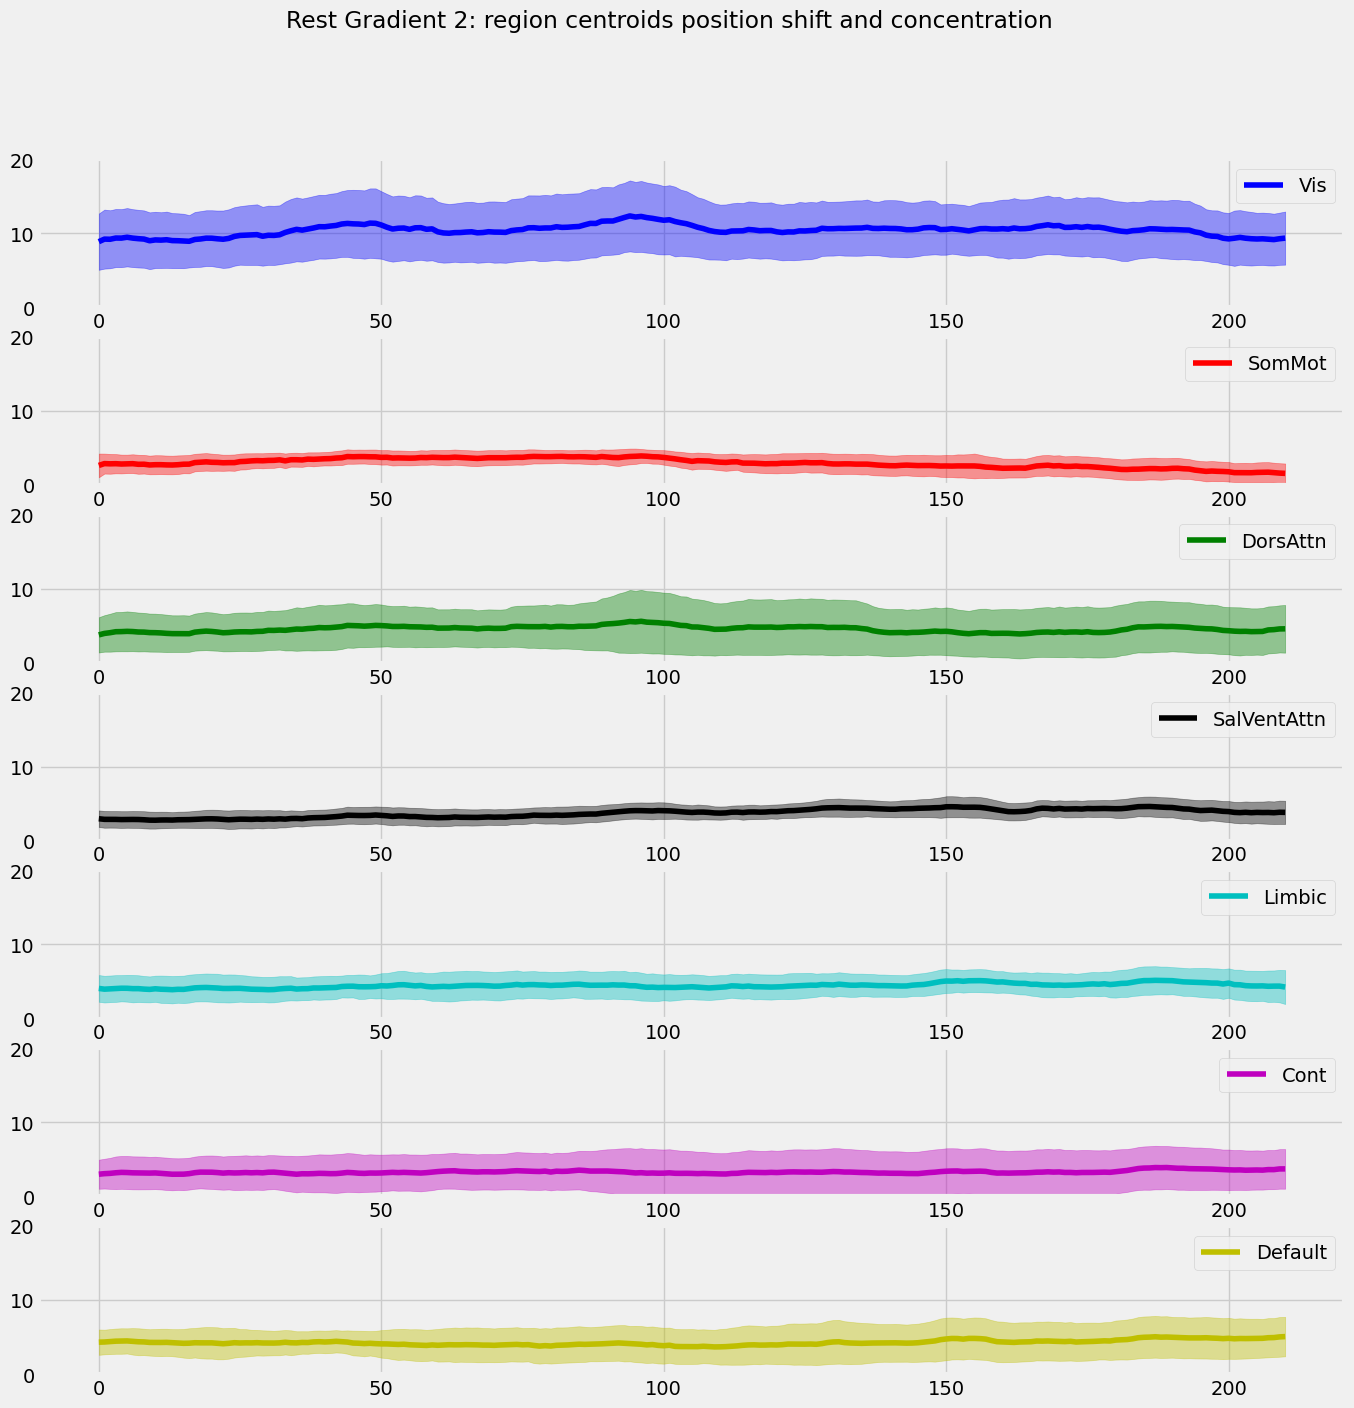

In [11]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
is_movie = 0
grad_idx = 1
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(gs[is_movie][:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(gs[is_movie][:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    ax[idx].set_ylim(0, 20)
plt.suptitle("Rest Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

Text(0.5, 0.98, 'Movie Gradient 1: region centroids position shift and concentration')

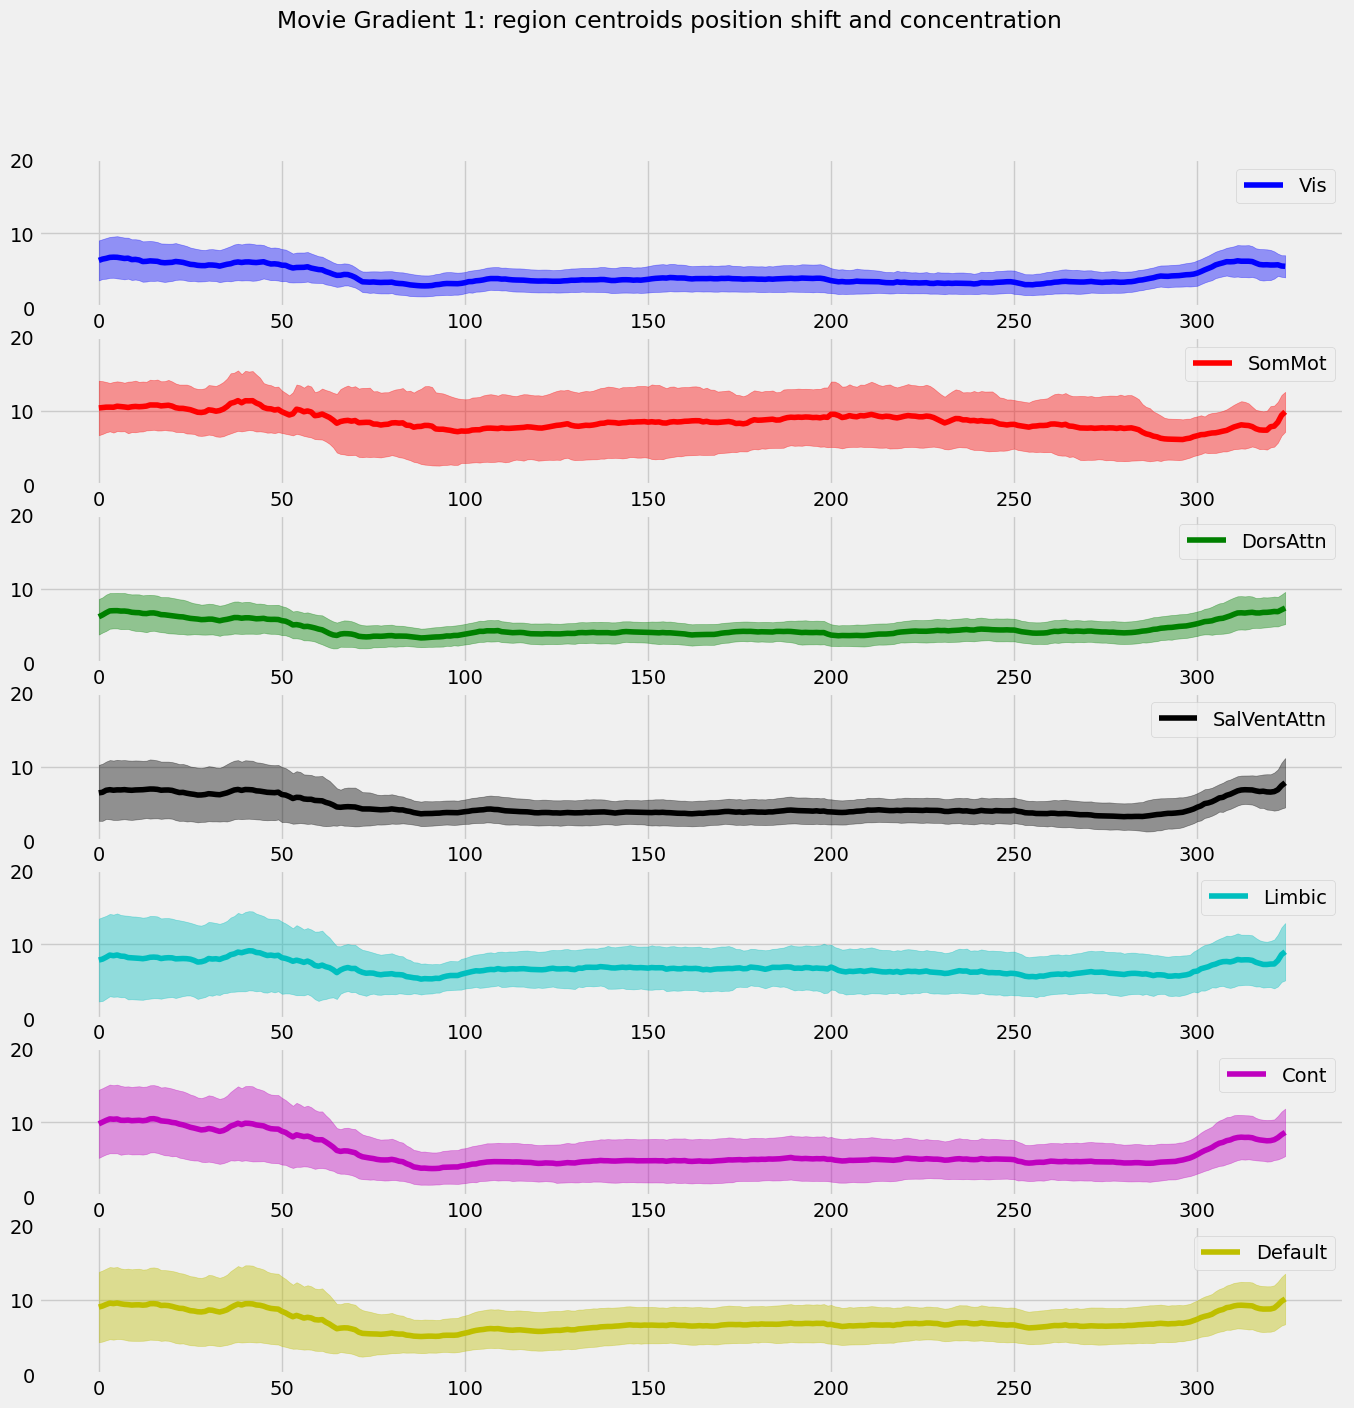

In [13]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
is_movie = 1
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(gs[is_movie][:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(gs[is_movie][:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    ax[idx].set_ylim(0, 20)
plt.suptitle("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

scripts to be dumped soon, just keeping for now in case

In [ ]:
# MANUAL ALIGNEMENT WITH FLIPPING USING PRIOR OF REGION LOCATION

# coloring  = [partial_region_movie[i] for i in range(400)]
# ts = ['rest', 'movie']

# gs = [G_rest, G_movie]
# ret_gs = [np.zeros_like(G_rest), np.zeros_like(G_movie)]

# tmp_df    = pd.DataFrame.from_dict({"G1":gs[0][0][:,0] , "G2": gs[0][0][:,1], "region": coloring})
# ref_sign1 = np.array(tmp_df[tmp_df['region']=='Default'].mean())
# tmp_df    = pd.DataFrame.from_dict({"G1":gs[1][0][:,0] , "G2": gs[1][0][:,1], "region": coloring})
# ref_sign2 = np.array(tmp_df[tmp_df['region']=='Default'].mean())
# ref_signs = [ref_sign1, ref_sign2]

# for i in range(2):
#     for j in tqdm(range(len(gs[i]))):
#         tmp_df = {"G1":gs[i][j][:,0] , "G2": gs[i][j][:,1], "region": coloring}
#         tmp_df = pd.DataFrame.from_dict(tmp_df)

#         # use default region position as a prior knowledge
#         cur_sign = np.array(tmp_df[tmp_df['region']=='Default'].mean())
#         # flip around x-y axis if not same sign
#         tmp_array = gs[i][j][:]
#         if np.sign(ref_signs[i][0]) != np.sign(cur_sign[0]):
#             tmp_array[:,0] = -tmp_array[:,0]
#         if np.sign(ref_signs[i][1]) != np.sign(cur_sign[1]):
#             tmp_array[:,1] = -tmp_array[:,1]
#         ret_gs[i][j] = tmp_array